## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

import math
import os
import h5py
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple
import temporaldata as td

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from temporaldata import Data
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [6]:
# Set max rows and cols for df display

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [ ]:
# Path to your data directory
# data_path = r"C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012"
data_path = "/ceph/aeon/aeon/SANe/brainsets_data/processed/churchland_shenoy_neural_2012"

# List all h5 files in the directory
h5_files = [f for f in os.listdir(data_path) if f.endswith('.h5')]
print(f"Available h5 files: {h5_files}")

# Change index to any file you want to load
file = os.path.join(data_path, h5_files[0])

# Read neural data from HDF5
with h5py.File(file, "r") as f:
    session = Data.from_hdf5(f)

    # Access neural data
    print("\nSpike timestamps:")
    print(session.spikes.timestamps)

    session.spikes.materialize()

    # List all available attributes (keys) in the session object
    attributes = dir(session)
    public_attrs = [attr for attr in dir(session) if not attr.startswith("__")]
    print("\nAvailable data keys in session:")
    for attr in public_attrs:
        print("-", attr)

Available h5 files: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5', 'nitschke_20090812_center_out_reaching.h5', 'nitschke_20090819_center_out_reaching.h5', 'nitschke_20090910_center_out_reaching.h5', 'nitschke_20090920_center_out_reaching.h5', 'nitschke_20090922_center_out_reaching.h5', 'nitschke_20100923_center_out_reaching.h5']

Spike timestamps:
[  64.5515       64.55153333   64.55163333 ... 8852.01523659 8852.01543659
 8852.01553659]

Available data keys in session:
- _absolute_start
- _check_for_data_leakage
- _domain
- absolute_start
- add_split_mask
- brainset
- cursor
- cursor_outlier_segments
- device
- domain
- end
- eye
- from_hdf5
- get_nested_attribute
- hand
- keys
- materialize
- movement_phases
- select_by_interval
- session
- set_test_domain
- set_train_domain
- set_valid_domain
- slice
- spikes
- start
- subject
- test_domain
- to_dict
- to_hdf5

In [8]:
import numpy as np
import pandas as pd

# Grab raw arrays
timestamps = session.spikes.timestamps
unit_ids = session.spikes.unit_index

# Parameters
bin_size = 0.05  # 10 ms
start = timestamps.min()
end = timestamps.max()
bins = np.arange(start, end + bin_size, bin_size)

# Create DataFrame
df_long = pd.DataFrame({
    'timestamp': timestamps,
    'unit': unit_ids
})

# Assign each spike to a time bin
df_long['bin'] = np.digitize(df_long['timestamp'], bins) - 1  # zero-based index

# Group by bin and unit, then count spikes
spk_cts_df = (
    df_long
    .groupby(['bin', 'unit'])
    .size()
    .unstack(fill_value=0)  # unit IDs become columns
)

# Convert bin index to actual time (bin start)
spk_cts_df.index = bins[spk_cts_df.index]
spk_cts_df.columns.name = None

# Result: each row = time bin, each col = unit, values = spike count
display(spk_cts_df)

,0,1,2,3,4,5,6,7,8,9,10,11,...,179,180,181,182,183,184,185,186,187,188,189,190
64.5515,0,1,5,2,3,0,3,2,3,2,5,5,...,2,4,3,1,0,5,3,2,2,1,3,0
64.6015,0,0,2,0,3,0,1,1,3,3,2,6,...,2,0,0,1,1,0,3,3,1,3,3,1
64.6515,1,0,1,0,1,0,0,0,3,3,4,4,...,2,2,2,0,0,0,0,1,2,0,0,3
64.7015,0,2,2,0,3,0,2,0,2,2,5,2,...,1,1,1,1,2,0,0,2,1,1,3,0
64.7515,0,0,1,0,0,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851.8015,0,1,2,3,3,10,5,4,7,2,6,2,...,2,4,2,4,3,3,2,4,4,2,3,5
8851.8515,0,4,7,2,4,11,7,6,8,7,8,4,...,5,4,6,5,4,4,4,6,4,5,4,6
8851.9015,0,7,3,4,5,10,6,6,6,7,7,6,...,2,1,3,1,1,1,2,3,1,1,3,2
8851.9515,0,3,7,2,9,9,13,6,6,6,9,8,...,3,0,0,0,2,3,1,0,1,1,0,0


In [9]:
"""Load spikes and set sae config."""

# gpu for training
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spk_cts = t.from_numpy(spk_cts_df.to_numpy()).bfloat16().to(device)
spk_cts /= spk_cts.max()  # max normalize spike counts

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(spk_cts)

device=device(type='cuda')


tensor([[0.0000, 0.0400, 0.2002,  ..., 0.0400, 0.1201, 0.0000],
        [0.0000, 0.0000, 0.0801,  ..., 0.1201, 0.1201, 0.0400],
        [0.0400, 0.0000, 0.0400,  ..., 0.0000, 0.0000, 0.1201],
        ...,
        [0.0000, 0.2793, 0.1201,  ..., 0.0400, 0.1201, 0.0801],
        [0.0000, 0.1201, 0.2793,  ..., 0.0400, 0.0000, 0.0000],
        [0.0000, 0.0801, 0.0000,  ..., 0.0000, 0.0000, 0.0400]],
       device='cuda:0', dtype=torch.bfloat16)

## Train MSAE

In [10]:

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 2240/2240 [01:46<00:00, 21.10it/s, loss=0.00609,  l0_mean=24.0, l0_std=7.374416828155518, frac_dead=0.89697265625] 


## Validate SAEs

In [11]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

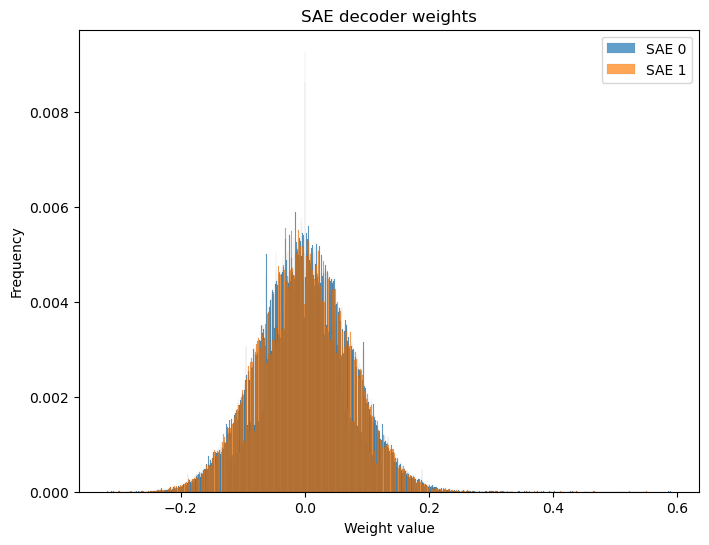

In [12]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 112/112 [00:01<00:00, 110.90it/s]


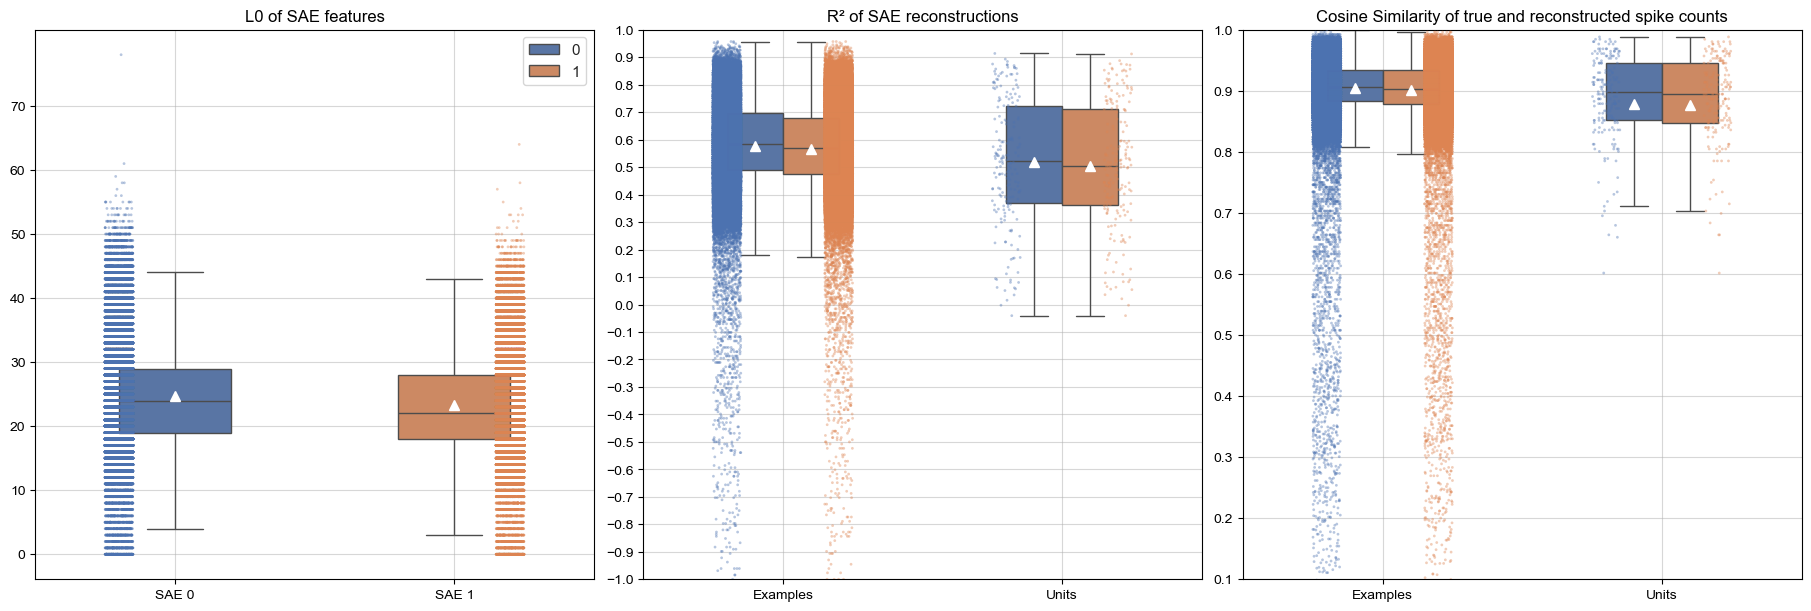

In [13]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

In [15]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.992
SAE instance 1 R² (summed spike count over all units per example) = 0.992


### Remove bad units and retrain.

In [16]:

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spk_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

frac units above r2_thresh=0.1: 0.93
Number to keep: 178 / 191


SAE batch training step: 100%|██████████| 2240/2240 [00:46<00:00, 47.95it/s, loss=0.00633,  l0_mean=24.0, l0_std=8.088844299316406, frac_dead=0.90234375]   


SAE batch evaluation step: 100%|██████████| 112/112 [00:00<00:00, 162.29it/s]


SAE instance 0 R² (summed spike count over all units per example) = 0.991
SAE instance 1 R² (summed spike count over all units per example) = 0.992


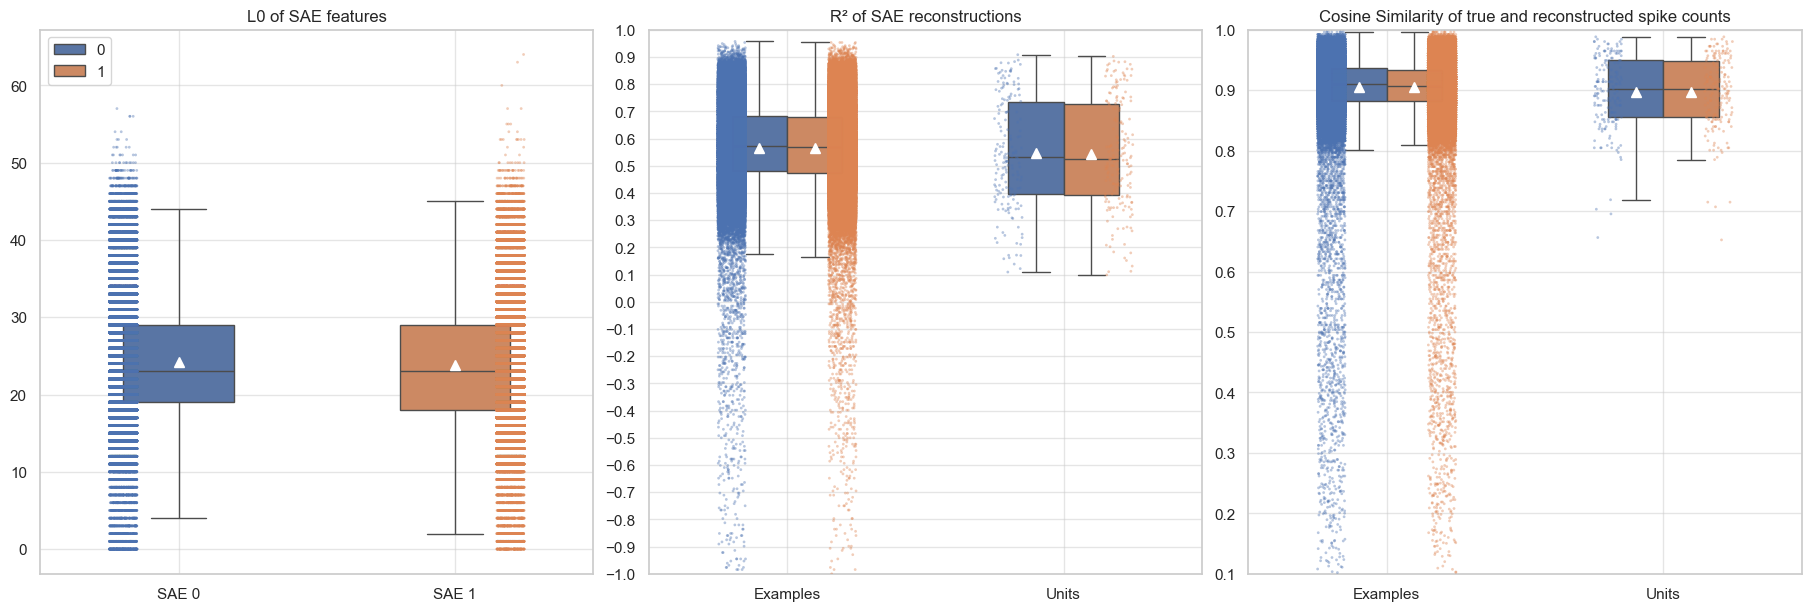

In [17]:
"""Re-Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


In [19]:
n_recon_examples

114688

## Get environment / behavior (meta)data

In [ ]:
"""Set vars for saving / loading environment / behavior (meta)data!"""

load_metadata = False
save_metadata = True
metadatafile = out_dir / f"{session_id}" / "metadata.csv"
bin_s = 0.05  # 50 ms sampling


In [ ]:
"""Load metadata."""

if load_metadata:
    metadata = pd.read_csv(metadatafile)

In [ ]:
"""Acquire metadata from Allen SDK."""

if not load_metadata:
    manifest_path = out_dir.parent / "manifest.json"
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    session_data = cache.get_session_data(session_id)
    metadata = session_data.get_stimulus_table()

    print("Invalid times:")
    display(session_data.get_invalid_times())

    # Add running, gaze, and pupil data to metadata if found.

    running_df = session_data.running_speed
    gaze_df = session_data.get_screen_gaze_data()
    pupil_df = session_data.get_pupil_data()

    print("Running speed:")
    display(running_df)
    print("Gaze data:")
    display(gaze_df)
    print("Pupil data:")
    display(pupil_df)

    # Reformat metadata
    metadata["start_time"] = round(metadata["start_time"] / bin_s) * bin_s
    metadata["stop_time"] = round(metadata["stop_time"] / bin_s) * bin_s

    init_vis_time = metadata.iloc[0]["start_time"]
    new_init_vis_idx = int(init_vis_time / bin_s) + 1

    time_range = np.arange(0, metadata.iloc[-1]["stop_time"] + bin_s, bin_s)
    time_df = pd.DataFrame({"time": pd.Series(time_range).round(2)})

    # Create a new dataframe with just the time points
    time_df["start_time"] = time_df["time"]
    time_df["stop_time"] = time_df["time"] + 0.05
    time_df["duration"] = 0.05

    # Merge the time_df with metadata
    metadata = pd.merge_asof(
        time_df.sort_values("time"),
        metadata.sort_values("start_time"),
        left_on="time",
        right_on="start_time",
        direction="backward"
    )

    # Merge additional behavioral data
    if running_df is not None:
        running_df["start_time"] = round(running_df["start_time"] / bin_s) * bin_s
        running_df["end_time"] = round(running_df["end_time"] / bin_s) * bin_s
        running_df = running_df.rename(columns={"start_time": "time"})

        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            running_df[["time", "velocity"]].sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if gaze_df is not None:
        # raw_pupil_area, raw_screen_coordinates_x_cm, raw_screen_coordinates_y_cm
        gaze_df.dropna(inplace=True)
        gaze_df = gaze_df.reset_index().rename(columns={"Time (s)": "time"})
        gaze_df["time"] = round(gaze_df["time"] / bin_s) * bin_s
        keep_cols = [
            "time", 
            "raw_pupil_area", 
            "raw_screen_coordinates_x_cm", 
            "raw_screen_coordinates_y_cm"
        ]
        drop_cols = gaze_df.columns.difference(keep_cols).tolist()
        gaze_df = gaze_df.drop(columns=drop_cols)
        
        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            gaze_df.sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if pupil_df is not None:
        print("ADD PUPIL DATA")
        # eye_center_x, eye_center_y, pupil_center_x, pupil_center_y

    # Clean up
    metadata = (metadata.
        set_index("time")
        .drop(columns=["start_time_x", "stop_time_x", "duration_x"])
        .rename(columns={"start_time_y": "start_time", "stop_time_y": "stop_time", "duration_y": "duration"})
    )

    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_condition_id"] = -1
    metadata["stimulus_condition_id"] = metadata["stimulus_condition_id"].astype(int)
    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_name"] = ""

    metadata.loc[metadata.index[0:new_init_vis_idx], "start_time"] = 0
    metadata.loc[metadata.index[0:new_init_vis_idx], "stop_time"] = init_vis_time
    metadata["duration"] = metadata["stop_time"] - metadata["start_time"]

    first_cols = [
        "stimulus_condition_id",
        "stimulus_name",
        "stimulus_block",
        "start_time",
        "stop_time",
        "duration",
        "orientation",
        "temporal_frequency",
        "spatial_frequency",
        "contrast",
        "x_position",
        "y_position"
    ]
    other_cols = metadata.columns.difference(first_cols).tolist()
    metadata = metadata.reindex(columns=(first_cols + other_cols))
    metadata = metadata.iloc[0:n_recon_examples].reset_index(drop=True)

    # Running window average of velocity
    window = int(0.25 / bin_s)  # 250 ms window
    metadata["velocity"] = metadata["velocity"].rolling(window=window, min_periods=1).mean()

In [ ]:
"""Save it."""
if save_metadata:
    csv_path = out_dir / f"{session_id}" / "metadata.csv"
    metadata.to_csv(csv_path, index=False)  

In [ ]:
display(metadata)

In [ ]:
metadata["stimulus_name"].unique()

In [ ]:
session_data.get_stimulus_parameter_values()

In [ ]:
stim_epochs = session_data.get_stimulus_epochs()
stim_epochs["start_idx"] = (stim_epochs["start_time"] / bin_s).astype(int)
stim_epochs["stop_idx"] = (stim_epochs["stop_time"] / bin_s).astype(int)
display(stim_epochs)

## Interpret features

In [ ]:
"""Set vars for saving / loading feature act data!"""

load_acts = False  # if True, will load saved feature activations
save_acts = True
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
"""Load feature activations data."""

if load_acts:
    acts_df = pd.read_csv(acts_df_save_path)

In [ ]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [ ]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

if save_acts:
    acts_df.to_csv(acts_df_save_path, index=False)

In [ ]:
display(acts_df)
display(features_df)

In [ ]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") groups"""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

In [ ]:
"""Visualize feature info"""

# top_n = dsae
# top_features = features_df.nlargest(top_n, "activation_count")
# plot_df = acts_df[acts_df["feature_idx"].isin(top_features["feature_idx"].tolist())]

# fig, ax = plt.subplots(figsize=(14, 8))
# sns.boxplot(x="feature_idx", y="activation_value", data=plot_df, showfliers=False, ax=ax)
# ax.set_title(f"Distributions of activation values for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Value")
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

# # Barplot of "feature on" counts
# fig, ax = plt.subplots(figsize=(14, 8))
# sns.barplot(x="feature_idx", y="activation_frac", data=features_df, ax=ax)
# ax.set_title(f"Feature activation count for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Count")
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# # ax.set_ylim(0, 0.01)
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

In [ ]:
"""Filter features by time active."""

tot_s = n_recon_examples * bin_s  
min_s_act = 5000
max_s_act = 10000
min_frac_act = min_s_act / tot_s
max_frac_act = max_s_act / tot_s
features_df = features_df[
    (features_df["activation_frac"] >= min_frac_act)
    & (features_df["activation_frac"] <= max_frac_act)
].reset_index(drop=True)

In [ ]:
pd.set_option("display.max_rows", 25)
features_df.sort_values("activation_mean", ascending=True)

In [ ]:
features_df.sort_values("activation_std", ascending=True)

In [ ]:
features_df.sort_values("act_mean_over_std", ascending=False)

In [ ]:
features_df.sort_values("activation_frac", ascending=True)

### Hunt for features

In [ ]:
"""Hunt for interesting features."""

features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False).head(20)

In [ ]:
"""Hunt for interesting features."""

features_df[features_df["feature_idx"] > last_feat_idx_general].sort_values("activation_frac", ascending=True).head(10)

In [ ]:
"""For a particular feature, get times it fired + stim deta at these times."""
inst_i, feat_i = 1, 1015
f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == inst_i, acts_df["feature_idx"] == feat_i)
]["example_idx"].values
print(f_ex_idxs.shape)
feat_metadata = metadata.loc[f_ex_idxs]
display(feat_metadata)

In [ ]:
2200 / 3900

In [ ]:
len(metadata[metadata["stimulus_name"].str.contains("grating", na=False)]) / 180000

In [ ]:
1181 / (1181 + 239 + 218 + 177 + 142)

In [ ]:
1/6

In [ ]:
feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]["spatial_frequency"].value_counts()

In [ ]:
# f_ex_idxs.shape
# start_idx = 2000
# metadata.iloc[f_ex_idxs][start_idx : start_idx + 200]
# plt.scatter(np.arange(0, 1000), metadata.iloc[f_ex_idxs].index[0:1000], marker=".", s=1)

# 250 rand ints without replacement between 0 and 7560
# rand_ints = np.random.choice(np.arange(0, 7560), size=250, replace=False)
# display(feat_metadata.iloc[rand_ints])

# Filter by if "grating" in stimulus_name
# feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]

# print(metadata.iloc[f_ex_idxs]["stimulus_name"].unique())

# # Generate 300 random ints between 100000 and 170000

# feat_metadata = metadata.iloc[f_ex_idxs]
# f_ex_idxs = feat_metadata.index
# display(feat_metadata)
# inst_i, feat_i = 0, 13


# print(feat_metadata[feat_metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique())

In [ ]:
5970 / 6520

In [ ]:
len(wys_idxs)

In [ ]:
"""Find wys features"""

wys_idxs = metadata[metadata["stimulus_name"] == "natural_scenes"].index
wys_acts_df = acts_df[acts_df["example_idx"].isin(wys_idxs)]
display(wys_acts_df)
feature_idxs = wys_acts_df["feature_idx"].value_counts().sort_values(ascending=False).head(10).index
print(feature_idxs)
# wys_acts_df[wys_acts_df["feature_idx"].isin(feature_idxs)]
features_df[features_df["feature_idx"].isin(feature_idxs)].sort_values("activation_frac", ascending=True)

# display(features_df[features_df["feature_idx"].isin(feature_idxs)].sort_values("activation_frac", ascending=True))

# high_vel_idxs = metadata["velocity"].sort_values(ascending=False)[0:1000].index

# # Sort features by how many counts they have at these times
# high_vel_acts_df = acts_df[acts_df["example_idx"].isin(high_vel_idxs)]
# feature_idxs = high_vel_acts_df["feature_idx"].value_counts().sort_values(ascending=False).head(10).index
# print(feature_idxs)
# high_vel_acts_df[high_vel_acts_df["feature_idx"].isin(feature_idxs)]

In [ ]:
"""Visualize feature activity vs. natural data."""

feat_act_ts = np.round(feat_metadata.index * 0.05, 2)
display(feat_act_ts)

df = stim_epochs.copy()
df["start_time"] = pd.to_numeric(df["start_time"])
df["stop_time"] = pd.to_numeric(df["stop_time"])
df["duration"] = df["stop_time"] - df["start_time"]
df["session"] = f"{session_id}"  # create dummy column for y-axis to place all bars on  same line
stimulus_types = df["stimulus_name"].unique()

fig = make_subplots(
    rows=2, 
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.8, 0.2]
)

fig.add_trace(
    go.Scatter(
        x=feat_act_ts,
        y=np.linspace(0, 1, len(feat_act_ts) + 1),
        mode="lines",
        name="Feature Activity",
        line=dict(color="black")
    ),
    row=1, col=1 # Assign to top subplot
)

# Highest single unit activity
max_col_name = spk_cts_df.iloc[f_ex_idxs].mean().idxmax()
unit_activity = spk_cts_df[max_col_name].values[:len(metadata)].cumsum()
unit_activity /= unit_activity[-1]

fig.add_trace(
    go.Scatter(
        x=np.round(metadata.index * bin_s, 2),
        y=unit_activity,
        mode="lines",
        name="top unit activity",
        line=dict(color="blue"),
        opacity=0.5,
    )
)

fig.add_trace(
    go.Scatter(
        x=np.round(metadata.index * bin_s, 2)[::5],
        y=(metadata["velocity"] / metadata["velocity"].max())[::5].fillna(0),
        mode="lines",
        name="running speed", # Name for legend
        line=dict(color="red"),
        opacity=0.3
    ),
    row=1, col=1 # Assign to top subplot
)

bar_hover_template = (
    "<b>Stimulus:</b> %{customdata[0]}<br>" +
    "<b>Start:</b> %{customdata[1]:.2f} s<br>" +
    "<b>Stop:</b> %{customdata[2]:.2f} s<br>" +
    "<b>Duration:</b> %{customdata[3]:.2f} s<br>" + # Access calculated duration
    "<extra></extra>"
)
cmap = px.colors.qualitative.Safe
colors = {stim: cmap[i % len(cmap)] for i, stim in enumerate(stimulus_types)}

for stim_type in stimulus_types:
    df_stim = df[df["stimulus_name"] == stim_type]
    fig.add_trace(
        go.Bar(
            x=df_stim["duration"],
            y=df_stim["session"], # Use the consistent session string
            base=df_stim["start_time"],
            orientation="h",
            name=stim_type,     # Use stimulus name for legend entry
            marker_color=colors[stim_type], # Assign color from map
            customdata=df_stim[["stimulus_name", "start_time", "stop_time", "duration"]],
            hovertemplate=bar_hover_template, # Apply template
            showlegend=True     # Ensure bars appear in legend
        ),
        row=2, col=1 # Assign to bottom subplot
    )

# Update layout
fig.update_yaxes(
    title_text="normalized cumulative count", # Y-axis title for top plot
    tickfont=dict(size=17),
    titlefont=dict(size=18),
    row=1, col=1
)
fig.update_yaxes(
    title_text="", # No title for bottom y-axis (category axis)
    showticklabels=False, # Make sure the category label shows
    row=2, col=1
)
fig.update_xaxes(
    title_text="time (s)", # X-axis title for bottom plot (shared axis)
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    tickfont=dict(size=17),
    titlefont=dict(size=19),
    tickangle=-45,
    row=2, col=1
)
fig.update_xaxes(
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    row=1, col=1
)

# Set title
fig.update_layout(title_text=
    f"({inst_i} : {feat_i}) feature activity; total time active: {len(feat_act_ts) * bin_s:.2f}s"
)

fig.update_layout(
    # Reduce margin space around the entire figure
    margin=dict(l=40, r=20, t=40, b=20),
    
    # Make the legend more compact
    legend=dict(
        # yanchor="top",
        y=0.999,  # 0.25
        # xanchor="left",
        x=0.001,  # 0.75
        font=dict(size=13),
        itemsizing='constant',  # Makes legend items smaller and more consistent
        # borderwidth=1,
        # orientation="h"  # Horizontal legend often takes less space
        # opacity=0.3
        bgcolor="rgba(255, 255, 255, 0.3)"
    ),
    
    # # Reduce title size and padding
    title=dict(
        font=dict(size=23),
        # yref='container',
        # y=0.98  # Push title to very top
    ),
    
    # # Make the plot itself take up more space
    # autosize=True,
    height=600,  # Adjust as needed
    width=1000    # Adjust as needed
)

# # Reduce tick label size and padding
# fig.update_xaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5  # Reduce space between axis and title
# )

# fig.update_yaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5
# )

fig.show()

In [ ]:
"""Filter properties of drifting gratings, static gratings, and gabors."""

# temporal_frequency
# feat_metadata["temporal_frequency"].value_counts()
print(feat_metadata[feat_metadata["stimulus_name"] == "drifting_gratings"]["temporal_frequency"].value_counts())

# fraction of stim which are drifting gratings
# sum(feat_metadata["stimulus_name"] == "drifting_gratings") / len(feat_metadata)

print(len(feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]) / len(feat_metadata))
# phase

# spatial_frequency

# x_position

# y_position

# orientation

In [ ]:
"""Filter properties of natural scenes and movies."""

# stimulus_condition_id

# frame

In [ ]:
pd.melt(spk_cts_df.iloc[f_ex_idxs])

In [ ]:
"""Visualize unit spiking variability over SAE feature activity."""

fig, ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(
    x="variable", 
    y="value", 
    data=pd.melt(spk_cts_df.iloc[f_ex_idxs]), 
    showfliers=False,
    width=1,
    whis=0.75, 
    ax=ax
)
ax.set_xlabel("units", fontsize=26)
ax.set_ylabel("normalized spike counts", fontsize=26)# ax.set_yticks([])
ax.set_xticklabels([])
# Set yticklabel font size
ax.tick_params(axis="y", labelsize=24)
ax.set_title(f"feature ({inst_i} : {feat_i}) normalized unit spike counts when active", fontsize=30)

In [ ]:
# fraction of data that is flashes
len(metadata[metadata["stimulus_name"] == "flashes"]) / len(metadata)

In [ ]:
11000 / 15000

In [ ]:
"""Visualize SAE-natural feature confusion matrix."""

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(
    x=[
        "gratings", 
        "gratings", 
        "gratings\n(spatial frequency = 0.04)", 
        "gratings\n(spatial frequency = 0.04)"
    ],
    height=[0.56, 0.37, 0.6, 0.17],
    color=["blue", "black", "blue", "black"],
    alpha=0.7,
    width=0.5
)

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.bar(
#     x=[
#         "flashes", 
#         "flashes", 
#     ],
#     height=[0.89, 0.03],
#     color=["blue", "black"],
#     alpha=0.7,
#     width=0.3
# )

ax.set_title(f"({inst_i} : {feat_i}) feature active on", fontsize=26)

# update fontsizes of ticks labels and titles
ax.tick_params(axis="x", labelsize=22)
ax.tick_params(axis="y", labelsize=19)
ax.set_ylabel("fraction of presentations", fontsize=22)
# ax.set_xticklabels(["drifting_gratings", "", "drifting_gratings\n(temporal frequency < 4 Hz)", ""])
ax.set_yticks(np.arange(0, 1.1, 0.1))

# fig.tight_layout()


In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

l0_act_frac = features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"] + 0.01

l1_act_frac = features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"] + 0.01

l2_act_frac = features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"] - 0.01
l2_act_frac = l2_act_frac.clip(lower=0)

# First, create a dataframe to hold all three sets of data with appropriate labels
boxplot_data = pd.DataFrame({
    "Layer": ["0 (General)"] * len(l0_act_frac) + 
             ["1 (Intermediate)"] * len(l1_act_frac) + 
             ["2 (Specific)"] * len(l2_act_frac),
    "Activation Fraction": pd.concat([l0_act_frac, l1_act_frac, l2_act_frac])
})

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Layer", 
    y="Activation Fraction", 
    data=boxplot_data,
    showfliers=False,  # This hides the outliers
    width=0.6,         # Controls the width of the boxes
    palette="viridis",  # Optional: choose a color palette
    # show mean
    showmeans=True,
    meanprops={"marker": "v", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10},
)

# Customize the plot
plt.title("Feature activation fraction by matryoshka level", fontsize=14)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Activation Fraction", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

acts_df_feat_on_idx = np.logical_and(
    acts_df["feature_idx"].isin(features_df["feature_idx"].unique()), 
    acts_df["instance_idx"] == 0
)

acts_df_comp = acts_df[acts_df_feat_on_idx].copy().drop(
    columns=["activation_value", "instance_idx"], axis=1
)

feature_idxs = np.sort(acts_df_comp["feature_idx"].unique())
corr_mat_idxs = np.arange(0, len(feature_idxs))
corr_mat_feat_idx_map = {feature_idxs[i]: corr_mat_idxs[i] for i in range(len(feature_idxs))}
acts_df_comp["corr_mat_idx"] = acts_df_comp["feature_idx"].map(corr_mat_feat_idx_map)

feat_on_mask = np.zeros((n_recon_examples, len(feature_idxs)))
feat_on_mask[acts_df_comp["example_idx"].values, acts_df_comp["corr_mat_idx"].values] = True

tot_feat_act = feat_on_mask.sum(axis=0)

feat_corr = t.tensor(feat_on_mask.T, device=device) @ t.tensor(feat_on_mask, device=device)
feat_corr_norm = (feat_corr / t.tensor(tot_feat_act, device=device).unsqueeze(0))

l0_co_idx = np.where(feature_idxs > 256)[0][0]
l1_co_idx = np.where(feature_idxs > 512)[0][0]

In [ ]:
# Create a heatmap

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    asnumpy(feat_corr_norm), 
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=range(feat_on_mask.shape[1]),
    yticklabels=range(feat_on_mask.shape[1]),
    ax=ax
)
ax.set_title("SAE feature conditional correlation matrix", fontsize=20)
ax.set_xlabel("SAE feature i", fontsize=16)
ax.set_ylabel("SAE feature j ( P(j | i) )", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Draw red horizontal and vertical lines at l0_co_idx and l1_co_idx
for idx in [l0_co_idx, l1_co_idx]:
    ax.axhline(y=idx, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=idx, color="red", linestyle="--", linewidth=2)

plt.tight_layout()

In [ ]:
metadata

In [ ]:
"""Visualize MSAE latents as bases of neural manifolds."""

# For SAE features: look at manifolds, feature activity over time (over stimuli xaxis bar), 
# extra: feature correlations ?

features_df.sort_values("activation_std", ascending=True)
acts_df_man = acts_df[acts_df["feature_idx"].isin([246, 41, 22])]
acts_df_man = acts_df_man[acts_df_man["instance_idx"] != 1]

In [ ]:
acts_df_man

In [ ]:
# Drop rows where instance_idx == 1

man_vals = np.zeros((n_recon_examples, 3))

for i, feat_i in enumerate([246, 41, 22]):
    idxs = acts_df_man[acts_df_man["feature_idx"] == feat_i]["example_idx"].values
    man_vals[idxs, i] = acts_df_man[acts_df_man["feature_idx"] == feat_i]["activation_value"].values


In [ ]:
# Create a DataFrame from the numpy array
man_df = pd.DataFrame(man_vals)
man_df.index = man_df.index * bin_s
man_df

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation

In [ ]:
# Enhanced version with better visuals and controls
def create_enhanced_3d_animation(df, save_path=None, fps=30, dpi=100):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract data
    x_data = df.iloc[:, 0].values
    y_data = df.iloc[:, 1].values
    z_data = df.iloc[:, 2].values
    
    # Calculate ranges for better visualization
    x_range = max(x_data) - min(x_data)
    y_range = max(y_data) - min(y_data)
    z_range = max(z_data) - min(z_data)
    
    # Set equal aspect ratio
    max_range = max(x_range, y_range, z_range) / 2
    mid_x = (max(x_data) + min(x_data)) / 2
    mid_y = (max(y_data) + min(y_data)) / 2
    mid_z = (max(z_data) + min(z_data)) / 2
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels and title
    ax.set_xlabel(df.columns[0], fontsize=12)
    ax.set_ylabel(df.columns[1], fontsize=12)
    ax.set_zlabel(df.columns[2], fontsize=12)
    ax.set_title('Top 3 SAE latents manifold over time', fontsize=14)
    
    # Add grid
    ax.grid(True)
    
    # Initialize line and point objects
    line, = ax.plot([], [], [], lw=2, color='blue')
    point, = ax.plot([], [], [], 'ro', markersize=10)
    
    # Add a shadow on the floor
    ax.plot(x_data, y_data, min(z_data), 'k--', alpha=0.2)
    
    # Add vector from origin to current point
    vector, = ax.plot([0, 0], [0, 0], [0, 0], 'g-', lw=1.5, alpha=0.7)
    
    # Time display
    time_template = 'Time = %.3f s'
    time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12)
    
    # Progress bar
    progress_bar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
    progress_bar = plt.Rectangle((0, 0), 0, 1, fc='blue', alpha=0.5)
    progress_bar_ax.add_patch(progress_bar)
    progress_bar_ax.set_xlim(0, 1)
    progress_bar_ax.set_ylim(0, 1)
    progress_bar_ax.axis('off')
    
    # Get time values
    if isinstance(df.index[0], (int, float)):
        times = df.index.values
    else:
        times = np.arange(len(df))
    
    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
        vector.set_data([], [])
        vector.set_3d_properties([])
        time_text.set_text('')
        progress_bar.set_width(0)
        return line, point, vector, time_text, progress_bar
    
    def update(frame):
        i = min(frame, len(df) - 1)
        progress = i / (len(df) - 1)
        
        # Update line data
        line.set_data(x_data[:i+1], y_data[:i+1])
        line.set_3d_properties(z_data[:i+1])
        
        # Update current point
        point.set_data([x_data[i]], [y_data[i]])
        point.set_3d_properties([z_data[i]])
        
        # Update vector from origin
        vector.set_data([0, x_data[i]], [0, y_data[i]])
        vector.set_3d_properties([0, z_data[i]])
        
        # Update time text
        current_time = times[i] if i < len(times) else times[-1]
        time_text.set_text(time_template % current_time)
        
        # Update progress bar
        progress_bar.set_width(progress)
        
        # Rotate view slightly for 3D effect
        ax.view_init(elev=30, azim=i / 5 % 360)
        
        return line, point, vector, time_text, progress_bar
    
    # Sample a reasonable number of frames
    num_frames = min(len(df), 300)
    frame_indices = np.linspace(0, len(df)-1, num_frames, dtype=int)
    
    ani = FuncAnimation(fig, update, frames=frame_indices,
                        init_func=init, blit=False, interval=1000/fps)
    
    if save_path:
        ani.save(save_path, writer='pillow', fps=fps, dpi=dpi)
        print(f"Enhanced animation saved to {save_path}")
    
    plt.close()
    return ani

# Use this enhanced version
save_path = out_dir / f"{session_id}" / "sae_features" / "sae_0" / "enhanced_3d_animation.gif"
enhanced_ani = create_enhanced_3d_animation(man_df.iloc[::500], save_path=save_path, fps=15, dpi=200)
# HTML(enhanced_ani.to_jshtml())

## Features found

### Possible

- flashes
- gabors

---

- flashes
- natural scenes / movies
- orientations or motion or running speed ?

---

High-level:

- fire for running speed?
- only fire for spontaneous?
- only fire for flashes?
- only fire for gabors in particular locations? -> single cell?
- only fire for motion? (drifting gratings, movies) -> single cell?
- only fire for certain orientations? -> single cell?
- only fire for natural scenes or movies?

### Actual

#### Session 732592105

##### sae_0

- 1 : 863

  - gratings (but not gabors) and particular natural scenes and particular frames from movies

#### Session 742851821

##### sae_0

## Scratchpad below here

In [ ]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [ ]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

In [ ]:
# session_data.presentationwise_spike_times()

In [ ]:
# session_data.conditionwise_spike_statistics()